In [1]:
import numpy as np
from scipy.spatial.distance import euclidean
import pandas as pd
from fastdtw import fastdtw
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date
from datetime import timedelta
import math

In [2]:
x = np.array([1,2,3,4,5])
y = np.array([10,9,8,7,6])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance, path)

25.0 [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]


In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import absolute_import, division

from collections import defaultdict

from six.moves import xrange


def fastdtw(x, y, radius=1, dist=lambda a, b: abs(a - b)):
    min_time_size = radius + 2

    if len(x) < min_time_size or len(y) < min_time_size:
        return dtw(x, y, dist=dist)

    x_shrinked = __reduce_by_half(x)
    y_shrinked = __reduce_by_half(y)
    distance, path = fastdtw(x_shrinked, y_shrinked, radius=radius, dist=dist)
    window = __expand_window(path, len(x), len(y), radius)
    return dtw(x, y, window, dist=dist)


def dtw(x, y, window=None, dist=lambda a, b: abs(a - b)):
    len_x, len_y = len(x), len(y)
    if window is None:
        window = [(i, j) for i in xrange(len_x) for j in xrange(len_y)]
    window = ((i + 1, j + 1) for i, j in window)
    D = defaultdict(lambda: (float('inf'),))
    D[0, 0] = (0, 0, 0)
    for i, j in window:
        dt = dist(x[i-1], y[j-1])
        D[i, j] = min((D[i-1, j][0]+dt, i-1, j), (D[i, j-1][0]+dt, i, j-1),
                      (D[i-1, j-1][0]+dt, i-1, j-1), key=lambda a: a[0])
    path = []
    i, j = len_x, len_y
    while not (i == j == 0):
        path.append((i-1, j-1))
        i, j = D[i, j][1], D[i, j][2]
    path.reverse()
    return (D[len_x, len_y][0], path)


def __reduce_by_half(x):
    return [(x[i] + x[1+i]) / 2 for i in xrange(0, len(x) - len(x) % 2, 2)]


def __expand_window(path, len_x, len_y, radius):
    path_ = set(path)
    for i, j in path:
        for a, b in ((i + a, j + b)
                     for a in xrange(-radius, radius+1)
                     for b in xrange(-radius, radius+1)):
            path_.add((a, b))

    window_ = set()
    for i, j in path_:
        for a, b in ((i * 2, j * 2), (i * 2, j * 2 + 1),
                     (i * 2 + 1, j * 2), (i * 2 + 1, j * 2 + 1)):
            window_.add((a, b))

    window = []
    start_j = 0
    for i in xrange(0, len_x):
        new_start_j = None
        for j in xrange(start_j, len_y):
            if (i, j) in window_:
                window.append((i, j))
                if new_start_j is None:
                    new_start_j = j
            elif new_start_j is not None:
                break
        start_j = new_start_j

    return window

In [11]:
censoreddf = pd.read_excel("Censored meters details.xlsx")

In [12]:
censoreddf.head()

,Starts from,MeterID,Solar size,EV inst_Date,Veh. Type
0,2020-02-01,KOL-22813398,1.133906,-,No
1,2020-02-01,KOL-22816106,1.133971,-,No
2,2020-02-01,KOL-22825185,1.134237,-,No
3,2020-02-01,KOL-22826374,1.134336,-,No
4,2020-02-01,KOL-22824523,1.134387,-,No


In [6]:
import os
path = "Gaussian Scores/"
dirListing = os.listdir(path)
editFiles = []
for item in dirListing:
    if ".csv" in item:
        #editFiles.append(item)
        i = os.path.splitext(item)[0]
        editFiles.append(i)
        #print editFiles

In [7]:
len(editFiles)

995

In [8]:
censoreddf = censoreddf[~censoreddf['MeterID'].isin(editFiles)]

In [13]:
censoreddf = censoreddf[10:200]

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Run for censored meter ids
for mid in censoreddf['MeterID']:
    df=pd.read_csv("Data_processed/"+mid+".csv")
    df['dates'] = df['dates'].str[:10]
    df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d')
    #df.drop(['device_id'], axis = 1, inplace=True)
    #Make all negative values to zero
    #num = df._get_numeric_data()
    #num[num < 0] = 0
    df = df.iloc[:,0:97].dropna(thresh=10)
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    #set index from column Date
    df = df.set_index('dates')
    dfScores = pd.DataFrame(columns = ['Main date', 'Distance'])
    for dt in df.index:
        lastdayfrom = pd.to_datetime(dt.date(), format='%Y-%m-%d')
        #if datetimeindex isn't order, order it
        df= df.sort_index()
        #last n days of date lastday
        lastday = lastdayfrom - timedelta(days = 1)
        df1 = df.loc[lastdayfrom - pd.Timedelta(days=90):lastday].reset_index()
        d1 = df.iloc[:,0:96][df.index == lastdayfrom].to_numpy()
        #prevdates = df1['dates']
        distances = []
        for prevdt in df1['dates']:
            odate=pd.to_datetime(prevdt, format='%Y-%m-%d')
            d2 = df1.iloc[:,1:97][df1.dates == odate].to_numpy()
            d = fastdtw(d1[0], d2[0])[0]
            distances.append(d)
        distances.sort()
        dfScores = dfScores.append({'Main date':lastdayfrom, 'Distance':np.mean(distances[:15])}, ignore_index = True)
        dfScores = dfScores.fillna(0)
        m = np.mean(dfScores['Distance'])
        s = np.std(dfScores['Distance'])
        dfScores['Distance'] = dfScores['Distance'].astype(float)
        distance = dfScores['Distance']
        GaussianScores = pd.DataFrame(columns = ['Main date', 'Distance', 'Gaussian Score'])
        for idx in range(0,len(distance)):
            #print(dfs['Distance'][idx])
            GaussianScore = max(0, math.erf((dfScores['Distance'][idx] - m)/((s)*np.sqrt(2))))
            GaussianScores = GaussianScores.append({'Main date':dfScores['Main date'][idx], 'Distance':dfScores['Distance'][idx], 'Gaussian Score': GaussianScore}, ignore_index = True)
    GaussianScores.to_csv("Gaussian Scores-PV/K=15/"+mid+".csv", index=False)

In [17]:
# Merge CP scores of all the customers into one file
import os
path = "Gaussian Scores-PV/K=15/"
dirListing = os.listdir(path)
editFiles = []
for item in dirListing:
    if ".csv" in item:
        #editFiles.append(item)
        i = os.path.splitext(item)[0]
        editFiles.append(i)

In [135]:
import os
path = "Data_normal/"
dirListing = os.listdir(path)
editFiles = []
for item in dirListing:
    if ".csv" in item:
        #editFiles.append(item)
        i = os.path.splitext(item)[0]
        editFiles.append(i)

In [141]:
import os
path = "Gaussian Scores_normal/"
dirListing = os.listdir(path)
editFiles1 = []
for item in dirListing:
    if ".csv" in item:
        #editFiles.append(item)
        i = os.path.splitext(item)[0]
        editFiles1.append(i)

In [149]:
editFiles2 = np.setdiff1d(editFiles, editFiles1)

In [153]:
# Run for normal meter ids
for mid in editFiles2:
    df=pd.read_csv("Data_normal/"+mid+".csv")
    df['dates'] = df['dates'].str[:10]
    df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d')
    df.drop(['device_id'], axis = 1, inplace=True)
    #Make all negative values to zero
    #num = df._get_numeric_data()
    #num[num < 0] = 0
    df = df.iloc[:,0:97].dropna(thresh=10)
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    #set index from column Date
    df = df.set_index('dates')
    dfScores = pd.DataFrame(columns = ['Main date', 'Distance'])
    for dt in df.index:
        lastdayfrom = pd.to_datetime(dt.date(), format='%Y-%m-%d')
        #if datetimeindex isn't order, order it
        df= df.sort_index()
        #last n days of date lastday
        lastday = lastdayfrom - timedelta(days = 1)
        df1 = df.loc[lastdayfrom - pd.Timedelta(days=90):lastday].reset_index()
        d1 = df.iloc[:,0:96][df.index == lastdayfrom].to_numpy()
        #prevdates = df1['dates']
        distances = []
        for prevdt in df1['dates']:
            odate=pd.to_datetime(prevdt, format='%Y-%m-%d')
            d2 = df1.iloc[:,1:97][df1.dates == odate].to_numpy()
            d = fastdtw(d1[0], d2[0])[0]
            distances.append(d)
        distances.sort()
        dfScores = dfScores.append({'Main date':lastdayfrom, 'Distance':np.mean(distances[:9])}, ignore_index = True)
        dfScores = dfScores.fillna(0)
        m = np.mean(dfScores['Distance'])
        s = np.std(dfScores['Distance'])
        dfScores['Distance'] = dfScores['Distance'].astype(float)
        distance = dfScores['Distance']
        GaussianScores = pd.DataFrame(columns = ['MeterID', 'Main date', 'Distance', 'Gaussian Score'])
        for idx in range(0,len(distance)):
            #print(dfs['Distance'][idx])
            GaussianScore = max(0, math.erf((dfScores['Distance'][idx] - m)/((s)*np.sqrt(2))))
            GaussianScores = GaussianScores.append({'MeterID': mid, 'Main date':dfScores['Main date'][idx], 'Distance':dfScores['Distance'][idx], 'Gaussian Score': GaussianScore}, ignore_index = True)
    GaussianScores.to_csv("Gaussian Scores_normal/"+mid+".csv", index=False)

In [9]:
df_EV_3W = pd.read_csv("EV-3W_Censored.csv") # To do after coming back

In [11]:
for mid in df_EV_3W['MeterID']:
    df=pd.read_csv("Data_processed-EV/3W/"+mid+".csv")
    df['dates'] = df['dates'].str[:10]
    df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d')
    #df.drop(['device_id'], axis = 1, inplace=True)
    #Make all negative values to zero
    #num = df._get_numeric_data()
    #num[num < 0] = 0
    df = df.iloc[:,0:97].dropna(thresh=10)
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    #set index from column Date
    df = df.set_index('dates')
    dfScores = pd.DataFrame(columns = ['Main date', 'Distance'])
    for dt in df.index:
        lastdayfrom = pd.to_datetime(dt.date(), format='%Y-%m-%d')
        #if datetimeindex isn't order, order it
        df= df.sort_index()
        #last n days of date lastday
        lastday = lastdayfrom - timedelta(days = 1)
        df1 = df.loc[lastdayfrom - pd.Timedelta(days=90):lastday].reset_index()
        d1 = df.iloc[:,0:96][df.index == lastdayfrom].to_numpy()
        #prevdates = df1['dates']
        distances = []
        for prevdt in df1['dates']:
            odate=pd.to_datetime(prevdt, format='%Y-%m-%d')
            d2 = df1.iloc[:,1:97][df1.dates == odate].to_numpy()
            d = fastdtw(d1[0], d2[0])[0]
            distances.append(d)
        distances.sort()
        dfScores = dfScores.append({'Main date':lastdayfrom, 'Distance':np.mean(distances[:9])}, ignore_index = True)
        dfScores = dfScores.fillna(0)
        m = np.mean(dfScores['Distance'])
        s = np.std(dfScores['Distance'])
        dfScores['Distance'] = dfScores['Distance'].astype(float)
        distance = dfScores['Distance']
        GaussianScores = pd.DataFrame(columns = ['Main date', 'Distance', 'Gaussian Score'])
        for idx in range(0,len(distance)):
            #print(dfs['Distance'][idx])
            GaussianScore = max(0, math.erf((dfScores['Distance'][idx] - m)/((s)*np.sqrt(2))))
            GaussianScores = GaussianScores.append({'Main date':dfScores['Main date'][idx], 'Distance':dfScores['Distance'][idx], 'Gaussian Score': GaussianScore}, ignore_index = True)
    GaussianScores.to_csv("Gaussian Scores-EV/GS-3W/"+mid+".csv", index=False)

In [16]:
df_EV_4W = pd.read_csv("EV-4W_Censored.csv")
df_EV_4W = df_EV_4W[30:]

In [17]:
for mid in df_EV_4W['MeterID']:
    df=pd.read_csv("Data_processed-EV/4W/"+mid+".csv")
    df['dates'] = df['dates'].str[:10]
    df['dates'] = pd.to_datetime(df['dates'], format='%Y-%m-%d')
    #df.drop(['device_id'], axis = 1, inplace=True)
    #Make all negative values to zero
    #num = df._get_numeric_data()
    #num[num < 0] = 0
    df = df.iloc[:,0:97].dropna(thresh=10)
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    #set index from column Date
    df = df.set_index('dates')
    dfScores = pd.DataFrame(columns = ['Main date', 'Distance'])
    for dt in df.index:
        lastdayfrom = pd.to_datetime(dt.date(), format='%Y-%m-%d')
        #if datetimeindex isn't order, order it
        df= df.sort_index()
        #last n days of date lastday
        lastday = lastdayfrom - timedelta(days = 1)
        df1 = df.loc[lastdayfrom - pd.Timedelta(days=90):lastday].reset_index()
        d1 = df.iloc[:,0:96][df.index == lastdayfrom].to_numpy()
        #prevdates = df1['dates']
        distances = []
        for prevdt in df1['dates']:
            odate=pd.to_datetime(prevdt, format='%Y-%m-%d')
            d2 = df1.iloc[:,1:97][df1.dates == odate].to_numpy()
            d = fastdtw(d1[0], d2[0])[0]
            distances.append(d)
        distances.sort()
        dfScores = dfScores.append({'Main date':lastdayfrom, 'Distance':np.mean(distances[:9])}, ignore_index = True)
        dfScores = dfScores.fillna(0)
        m = np.mean(dfScores['Distance'])
        s = np.std(dfScores['Distance'])
        dfScores['Distance'] = dfScores['Distance'].astype(float)
        distance = dfScores['Distance']
        GaussianScores = pd.DataFrame(columns = ['MeterID', 'Main date', 'Distance', 'Gaussian Score'])
        for idx in range(0,len(distance)):
            #print(dfs['Distance'][idx])
            GaussianScore = max(0, math.erf((dfScores['Distance'][idx] - m)/((s)*np.sqrt(2))))
            GaussianScores = GaussianScores.append({'MeterID': mid, 'Main date':dfScores['Main date'][idx], 'Distance':dfScores['Distance'][idx], 'Gaussian Score': GaussianScore}, ignore_index = True)
    GaussianScores.to_csv("Gaussian Scores-EV/GS-4W/"+mid+".csv", index=False)

In [386]:
#For plotting the consumption only
df2 = pd.melt(df, 
            id_vars='dates', 
            value_vars=list(df.columns[1:]),
            var_name='time', 
            value_name='kwh')

In [387]:
df2["dates"] = pd.to_datetime(df2["dates"])
df2["time"] = pd.to_timedelta(df2["time"])
df2["datetime"] = df2["dates"] + df2["time"]
df2 = df2.drop(['dates','time'], axis = 1)

In [5]:
#set index from column Date
#df2 = df2.set_index('datetime')
df = df.set_index('dates')

In [ ]:
df2.loc['2019-12'].plot(), df2.loc['2020-01'].plot(), df2.loc['2020-02'].plot()

In [77]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [78]:
path = dtw.warping_path(d1[0], d2[0])
dtwvis.plot_warping(d1[0], d2[0], path)
distance = dtw.distance(d1[0], d2[0])

NameError: name 'd1' is not defined

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

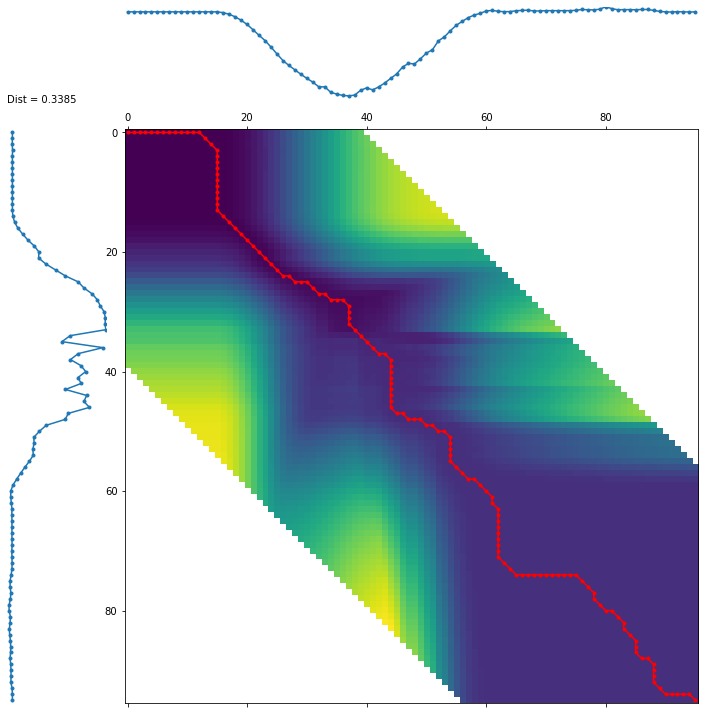

In [16]:
d, paths = dtw.warping_paths(d1[0], d2[0], window=40)
best_path = dtw.best_path(paths)
#dtwvis.plot_warpingpaths(d1[0], d2[0], paths, best_path, filename="warp.png")
dtwvis.plot_warpingpaths(d1[0], d2[0], paths, best_path)

In [154]:
# Merge CP scores of all the customers into one file
import os
path = "Gaussian Scores_normal/"
dirListing = os.listdir(path)
editFiles = []
for item in dirListing:
    if ".csv" in item:
        #editFiles.append(item)
        i = os.path.splitext(item)[0]
        editFiles.append(i)

In [155]:
len(editFiles)

630

In [156]:
fdf = pd.DataFrame()

In [157]:
for mid in editFiles:
    Gdf=pd.read_csv("Gaussian Scores_normal/"+mid+".csv")
    #Gdf['MeterID'] = mid
    fdf = fdf.append(Gdf)

In [159]:
fdf['MeterID'].nunique()

630

In [98]:
m1 = meteridlist[:700]
m2 = meteridlist[700:1400]
m3 = meteridlist[1400:2100]
m4 = meteridlist[2100:2800]
m5 = meteridlist[2800:]

In [99]:
fdf1 = fdf[fdf['MeterID'].isin(m1)]
fdf2 = fdf[fdf['MeterID'].isin(m2)]
fdf3 = fdf[fdf['MeterID'].isin(m3)]
fdf4 = fdf[fdf['MeterID'].isin(m4)]
fdf5 = fdf[fdf['MeterID'].isin(m5)]

In [100]:
fdf1.nunique(), fdf2.nunique()

(Main date            408
 Distance          246015
 Gaussian Score    106502
 MeterID              700
 dtype: int64, Main date            395
 Distance          253478
 Gaussian Score    107297
 MeterID              700
 dtype: int64)

In [96]:
fdf1.to_csv("CP_Scores-2903_1.csv", index=False, columns=['Main date','Gaussian Score','MeterID'])
fdf2.to_csv("CP_Scores-2903_2.csv", index=False, columns=['Main date','Gaussian Score','MeterID'])
fdf3.to_csv("CP_Scores-2903_3.csv", index=False, columns=['Main date','Gaussian Score','MeterID'])
fdf4.to_csv("CP_Scores-2903_4.csv", index=False, columns=['Main date','Gaussian Score','MeterID'])
fdf5.to_csv("CP_Scores-2903_5.csv", index=False, columns=['Main date','Gaussian Score','MeterID'])

In [101]:
fdf1.to_csv("CP_Scores-2903_1.csv", index=False, columns=['Main date','Gaussian Score','MeterID'])

In [130]:
m6 = meteridlist[:61]
fdf6 = fdf[fdf['MeterID'].isin(m6)]

In [131]:
m6

array(['KOL-22812974', 'KOL-22812979', 'KOL-22812980', 'KOL-22812998',
       'KOL-22813000', 'KOL-22813006', 'KOL-22813007', 'KOL-22813024',
       'KOL-22813027', 'KOL-22813035', 'KOL-22813036', 'KOL-22813107',
       'KOL-22813117', 'KOL-22813134', 'KOL-22813144', 'KOL-22813145',
       'KOL-22813161', 'KOL-22813162', 'KOL-22813168', 'KOL-22813180',
       'KOL-22813186', 'KOL-22813189', 'KOL-22813193', 'KOL-22813197',
       'KOL-22813200', 'KOL-22813204', 'KOL-22813209', 'KOL-22813210',
       'KOL-22813215', 'KOL-22813218', 'KOL-22813219', 'KOL-22813220',
       'KOL-22813222', 'KOL-22813225', 'KOL-22813235', 'KOL-22813238',
       'KOL-22813241', 'KOL-22813251', 'KOL-22813256', 'KOL-22813257',
       'KOL-22813263', 'KOL-22813264', 'KOL-22813266', 'KOL-22813270',
       'KOL-22813271', 'KOL-22813282', 'KOL-22813287', 'KOL-22813299',
       'KOL-22813311', 'KOL-22813320', 'KOL-22813321', 'KOL-22813324',
       'KOL-22813337', 'KOL-22813341', 'KOL-22813353', 'KOL-22813358',
      

In [ ]:
fdf = fdf[fdf.MeterID != 'KOL-22813398'] # date format of this id is un even so removed
fdf.nunique()

In [151]:
fdf.head()

,Main date,Distance,Gaussian Score,MeterID
0,2019-12-01,0.000000,0.000000,KOL-22812974
1,2019-12-02,1.905000,0.103570,KOL-22812974
2,2019-12-03,1.535250,0.000000,KOL-22812974
3,2019-12-04,1.752167,0.027129,KOL-22812974
4,2019-12-05,1.316875,0.000000,KOL-22812974


In [152]:
fdf.to_csv("CP_Scores-2902.csv", index=False)

In [160]:
fdf.head()

,MeterID,Main date,Distance,Gaussian Score
0,KOL-22814336,2019-12-01,0.000000,0.000000
1,KOL-22814336,2019-12-02,0.777000,0.137597
2,KOL-22814336,2019-12-03,0.544500,0.000000
3,KOL-22814336,2019-12-04,0.860167,0.235913
4,KOL-22814336,2019-12-05,0.750875,0.106189


In [165]:
fdf_pivot=fdf.pivot_table(index='MeterID', columns='Main date', values='Distance')

In [166]:
fdf_pivot

Main date,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
MeterID,,,,,,,,,,,,,,,,,,,,,
KOL-22814336,0.0,0.7770,0.54450,0.860167,0.750875,0.5908,1.220500,0.784071,0.748438,0.687944,...,2.795222,0.447778,1.220111,0.636000,0.436667,1.018667,0.505111,0.874944,0.673611,0.788333
KOL-22814340,0.0,0.5065,0.39750,0.397667,0.349875,0.3338,0.407250,0.480286,0.545188,0.384889,...,0.305444,0.363778,0.300333,0.296111,0.285778,0.288778,0.345889,0.260333,0.342111,0.341278
KOL-22814341,0.0,0.3385,0.54525,0.776500,0.943625,0.7223,0.979667,0.949714,0.912500,1.535500,...,0.864667,0.272333,0.578556,1.123333,0.551667,0.352889,0.504778,0.287222,0.725333,0.456333
KOL-22814342,0.0,2.1145,1.52425,1.382000,1.065250,1.0456,1.612083,1.290286,1.093062,1.010722,...,0.991333,0.521556,1.777000,1.637556,1.280889,1.081000,0.709667,1.576333,1.001667,1.346444
KOL-22814349,0.0,0.0120,0.01200,0.013333,0.009250,0.0144,0.010000,0.122571,0.022625,0.109000,...,0.016778,0.018556,0.021889,0.018333,0.018222,0.219333,0.009556,0.044111,0.035778,0.068222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KOL-22815214,0.0,0.9645,0.60925,0.765833,0.589875,0.4813,0.741750,0.526286,0.526250,0.517056,...,0.176611,0.193278,0.202000,0.286333,0.145778,0.130111,0.342000,0.114000,0.224167,0.128889
KOL-22815215,0.0,0.9280,1.09325,1.174333,0.832625,1.0906,0.970250,0.920714,0.991625,0.998389,...,1.275667,0.849111,0.775278,0.647889,0.697889,0.383889,0.389111,0.400222,0.766333,0.886222
KOL-22815216,0.0,0.2435,0.29875,0.501000,0.406375,0.2892,0.295417,0.573429,0.307750,0.273556,...,1.165111,0.449722,0.434278,0.351722,0.305167,0.292667,0.260944,0.249167,0.223611,0.298722


In [167]:
fdf_pivot.to_csv("CP_scores_Distance-630.csv")